# Weather Data Prediction 
### This notebook uses a Ridge regression model to predict high and low temperatures of data from May 2023 to July 2024.

In [15]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
df = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration and Cleaning

In [16]:
df.isnull().sum()

location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [17]:
# Drop Columns of No Interest
df = df.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

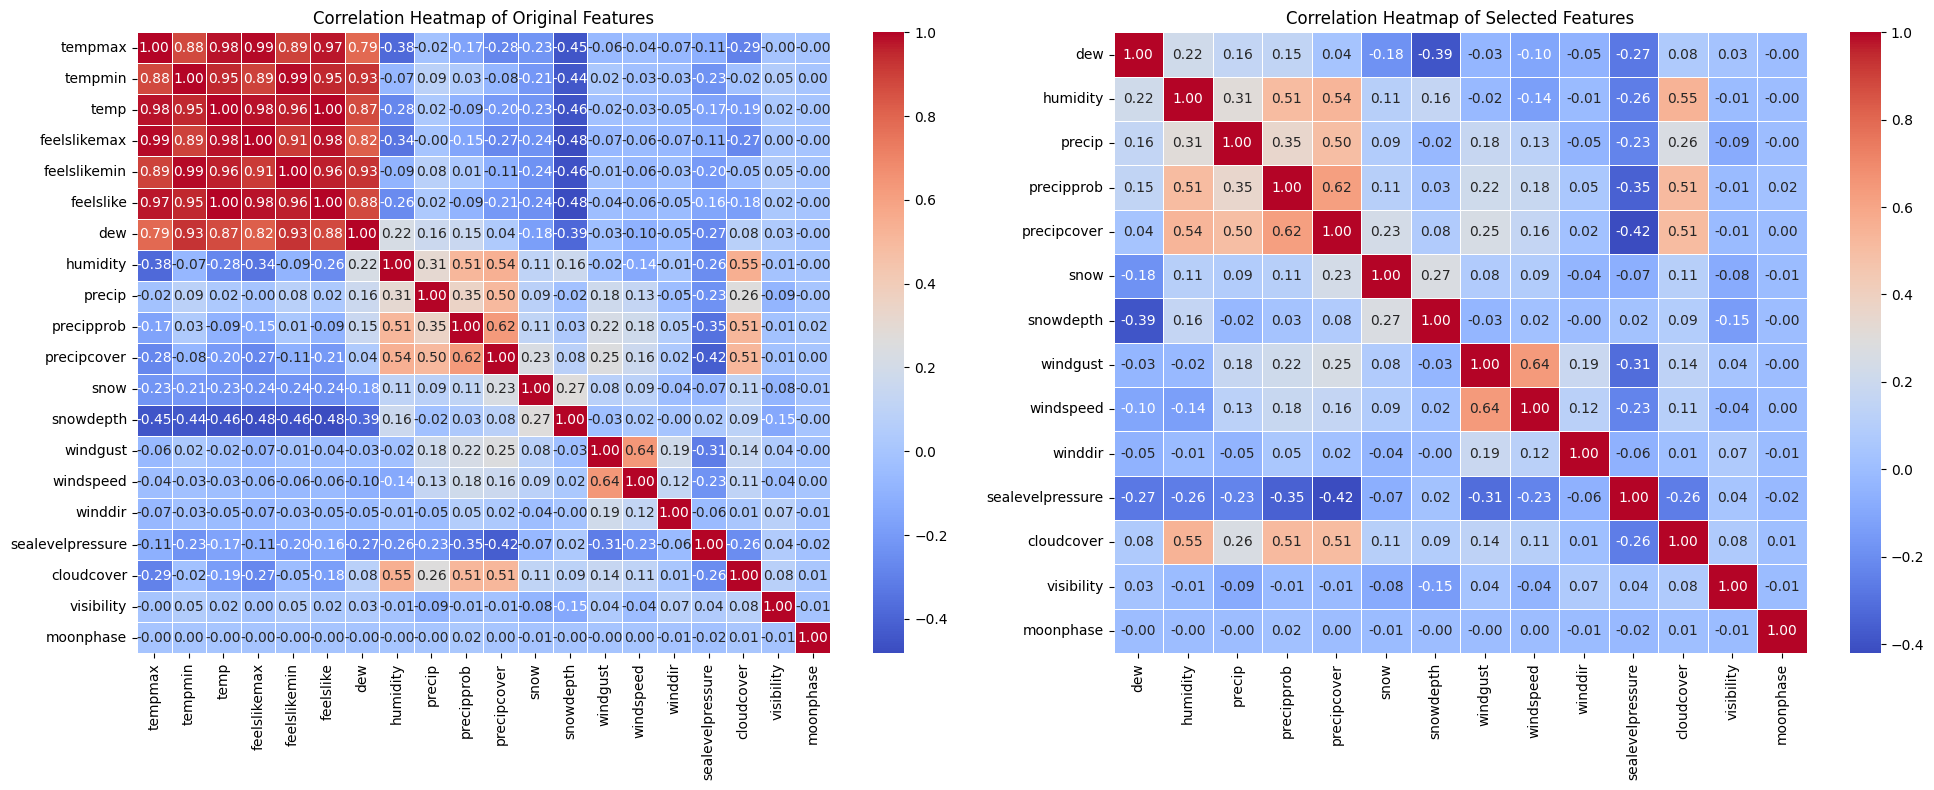

In [18]:
# Select only numerical columns from the DataFrame
features = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for original features
corr_matrix = features.corr()

# Drop highly correlated features
selected_features = features[['dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

# Calculate the correlation matrix for selected features
corr_matrix_selected = selected_features.corr()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot the heatmap for original features
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap of Original Features')

# Plot the heatmap for selected features
sns.heatmap(corr_matrix_selected, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap of Selected Features')

# Show the plot
plt.tight_layout()
plt.show()

### Addressing Multicollinearity - VIF Test Results 
Feature VIF
- dew  1.510584
- humidity  2.085587
- precip  1.400609
- precipprob  1.943016
- precipcover  2.514365
- snow  1.156531
- snowdepth  1.369926
- windgust  1.874062
- windspeed  1.856105
- winddir  1.057459
- sealevelpressure  1.445325
- cloudcover  1.695674
- visibility  1.066129
- moonphase  1.001601

## Fit linear model and test linearity in data

Likelihood Ratio Test:
- LR Statistic: 773.5384528999584
- p-value: 3.818608282633119e-155
- The polynomial model significantly improves the fit, indicating non-linearity.

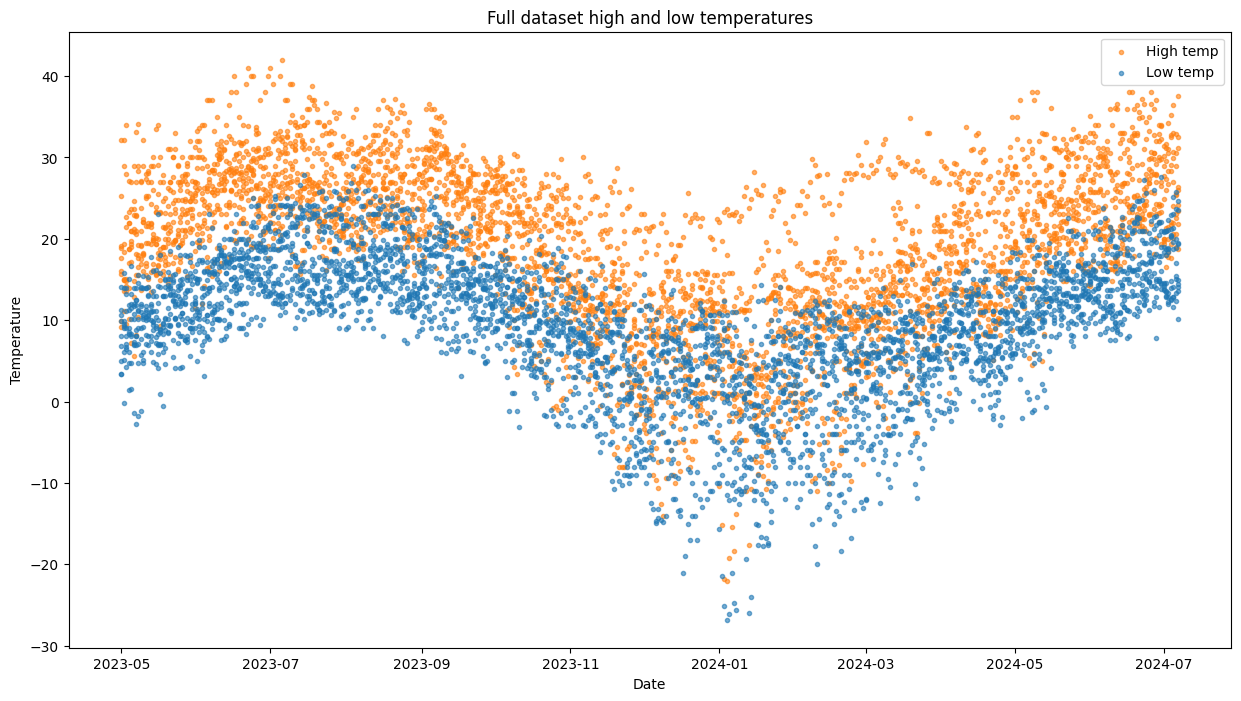

In [19]:
# Split data
# Plot the tempmax and tempmin values
fig, ax = plt.subplots(figsize=(15, 8))
plt.scatter(df.index, df['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(df.index, df['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Train/Validate/Test Split

In [20]:
# Split training and testing data by dates
train = df.loc[df.index < '2024-03-01']
validate = df.loc[(df.index >= '2024-03-01') & (df.index < '2024-04-13')]
test = df.loc[df.index >= '2024-04-13']

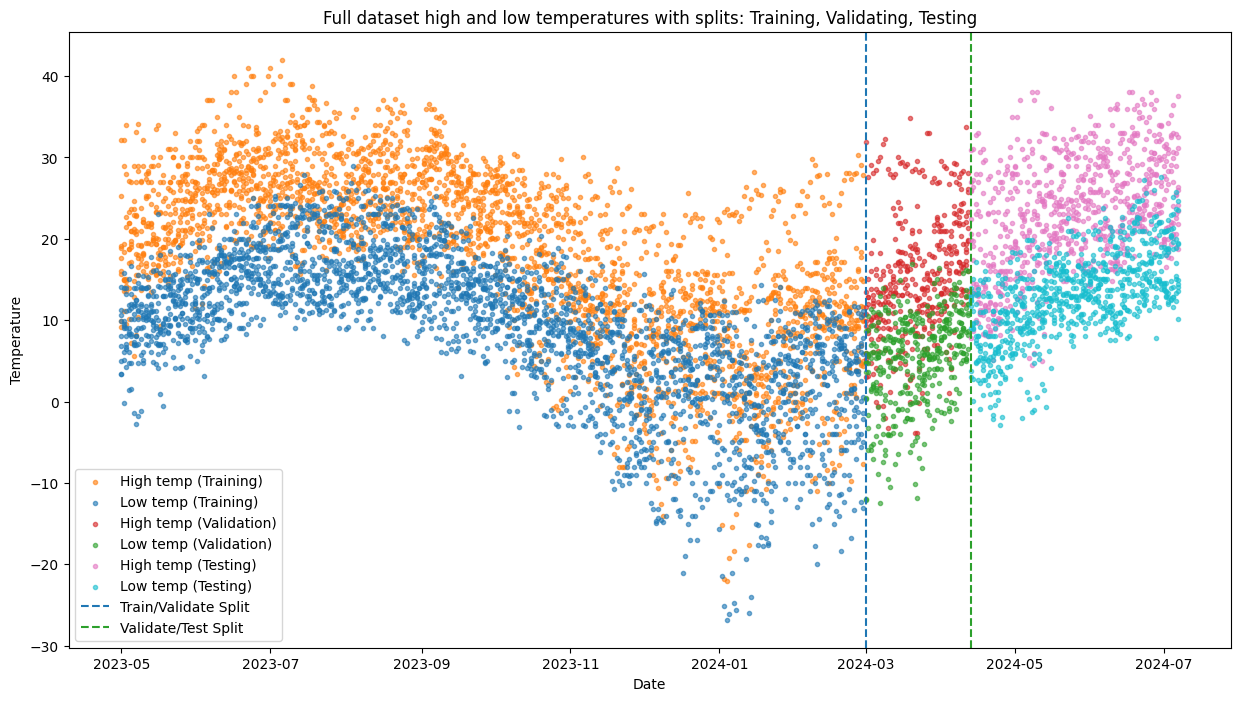

In [21]:
# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

# Split the data into before and after the split date
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

# Create the scatter plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the tempmax and tempmin columns for training data
plt.scatter(train.index, train['tempmax'], color=color_pal[1], label='High temp (Training)', alpha=0.6, marker='.')
plt.scatter(train.index, train['tempmin'], color=color_pal[0], label='Low temp (Training)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for validation data
plt.scatter(validate.index, validate['tempmax'], color=color_pal[3], label='High temp (Validation)', alpha=0.6, marker='.')
plt.scatter(validate.index, validate['tempmin'], color=color_pal[2], label='Low temp (Validation)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for testing data
plt.scatter(test.index, test['tempmax'], color=color_pal[6], label='High temp (Testing)', alpha=0.6, marker='.')
plt.scatter(test.index, test['tempmin'], color=color_pal[9], label='Low temp (Testing)', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures with splits: Training, Validating, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[0], ls='--', label='Train/Validate Split')
ax.axvline(validate_end_date, color=color_pal[2], ls='--', label='Validate/Test Split')

# Add legend
plt.legend()

# Show the plot
plt.show()


## Create Model

### Initialize and Train the Model - TempMax

In [22]:
# Define features and target for TempMax
X_max = ['dew', 'humidity', 'precip', 'precipprob', 'precipcover',
        'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
        'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']
y_max = 'tempmax'

# Define features and target for TempMin
X_min = ['dew', 'humidity', 'precip', 'precipprob', 'precipcover',
        'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
        'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']
y_min = 'tempmin'

In [23]:
# Define features and target for TempMax
X_train_max = train[X_max]
y_train_max = train[y_max]

# Define features and target for TempMin
X_train_min = train[X_min]
y_train_min = train[y_min]

# Initialize and train the Random Forest model - TempMax
rf_max = RandomForestRegressor(n_estimators=100, random_state=42)
rf_max.fit(X_train_max, y_train_max)

# Initialize and train the Random Forest model - TempMin
rf_min = RandomForestRegressor(n_estimators=100, random_state=42)
rf_min.fit(X_train_min, y_train_min)

# Evaluate the model using cross-validation - TempMax
cv_scores_max = cross_val_score(rf_max, X_train_max, y_train_max, cv=5)
print(f"Cross-Validation Scores Features - TempMin: {cv_scores_max}")
print(f"Mean CV Score Features - TempMin: {cv_scores_max.mean()}")

# Evaluate the model using cross-validation - TempMin
cv_scores_min = cross_val_score(rf_min, X_train_min, y_train_min, cv=5)
print(f"Cross-Validation Scores Features - TempMin: {cv_scores_min}")
print(f"Mean CV Score Features - TempMin: {cv_scores_min.mean()}")


# Apply the same model to the validation set - TempMax
X_val_max = validate[X_max]
y_val_max = validate[y_max]

# Apply the same model to the validation set - TempMin
X_val_min = validate[X_min]
y_val_min = validate[y_min]

# Predict and calculate R² score - TempMax
y_pred_max = rf_max.predict(X_val_max)
r2_score_max = r2_score(y_val_max, y_pred_max)
print(f"R² Score Features - TempMax: {r2_score_max}")

# Predict and calculate R² score - TempMin
y_pred_min = rf_min.predict(X_val_min)
r2_score_min = r2_score(y_val_min, y_pred_min)
print(f"R² Score Features - TempMin: {r2_score_min}")

Cross-Validation Scores Features - TempMin: [0.92793818 0.91855154 0.93444525 0.97448654 0.93745847]
Mean CV Score Features - TempMin: 0.9385759961035642
Cross-Validation Scores Features - TempMin: [0.92573108 0.87211054 0.93306915 0.97074152 0.94946184]
Mean CV Score Features - TempMin: 0.930222824895148
R² Score Features - TempMax: 0.8094642343584781
R² Score Features - TempMin: 0.8637454797723633


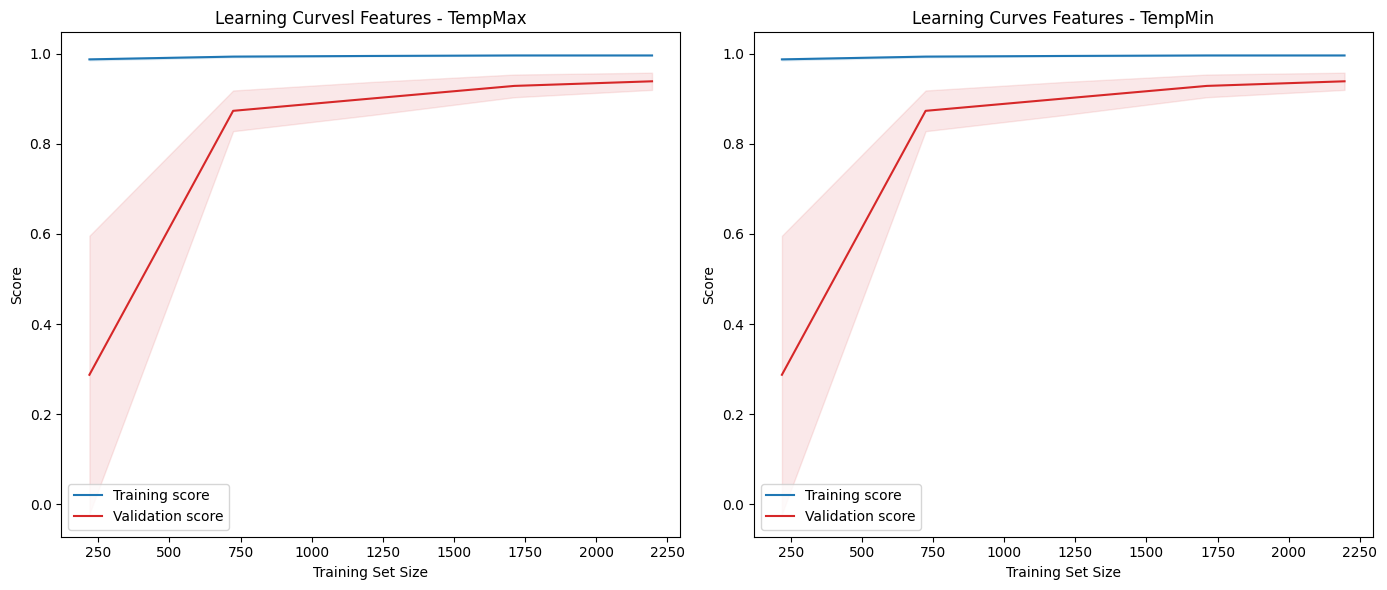

In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curves for Random Forest model features - TempMax
train_sizes_max, train_scores_max, val_scores_max = learning_curve(
    rf_max, X_train_max, y_train_max, cv=5, n_jobs=-1,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0]
)

# Generate learning curves for Random Forest model features - TempMin
train_sizes_min, train_scores_min, val_scores_min = learning_curve(
    rf_min, X_train_min, y_train_max, cv=5, n_jobs=-1,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0]
)

# Calculate the mean and std deviation of training and validation scores - TempMax
train_mean_max = train_scores_max.mean(axis=1)
val_mean_max = val_scores_max.mean(axis=1)
train_std_max = train_scores_max.std(axis=1)
val_std_max = val_scores_max.std(axis=1)

# Calculate the mean and std deviation of training and validation scores - TempMin
train_mean_min = train_scores_min.mean(axis=1)
val_mean_min = val_scores_min.mean(axis=1)
train_std_min = train_scores_min.std(axis=1)
val_std_min = val_scores_min.std(axis=1)

# Plot learning curves
plt.figure(figsize=(14, 6))

# Learning curves - TempMax
plt.subplot(1, 2, 1)
plt.plot(train_sizes_max, train_mean_max, label='Training score', color=color_pal[0])
plt.plot(train_sizes_max, val_mean_max, label='Validation score', color=color_pal[3])
plt.fill_between(train_sizes_max, train_mean_max - train_std_max, train_mean_max + train_std_max, alpha=0.1, color=color_pal[0])
plt.fill_between(train_sizes_max, val_mean_max - val_std_max, val_mean_max + val_std_max, alpha=0.1, color=color_pal[3])
plt.title('Learning Curvesl Features - TempMax')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend()

# Learning curves - TempMin
plt.subplot(1, 2, 2)
plt.plot(train_sizes_min, train_mean_min, label='Training score', color=color_pal[0])
plt.plot(train_sizes_min, val_mean_min, label='Validation score', color=color_pal[3])
plt.fill_between(train_sizes_min, train_mean_min - train_std_min, train_mean_min + train_std_min, alpha=0.1, color=color_pal[0])
plt.fill_between(train_sizes_min, val_mean_min - val_std_min, val_mean_min + val_std_min, alpha=0.1, color=color_pal[3])
plt.title('Learning Curves Features - TempMin')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


## Feature Engineering and Analysis

Feature: dew, Importance: 0.7168194394845575
Feature: humidity, Importance: 0.18716932712718345
Feature: snowdepth, Importance: 0.06139042460021497
Feature: cloudcover, Importance: 0.007355611229608409
Feature: sealevelpressure, Importance: 0.006866656791464065
Feature: visibility, Importance: 0.004792372619391761
Feature: windgust, Importance: 0.0036641806833900645
Feature: moonphase, Importance: 0.003277837840314604
Feature: winddir, Importance: 0.0032576726012653353
Feature: windspeed, Importance: 0.002876894374560408
Feature: precip, Importance: 0.0014592050892947334
Feature: precipcover, Importance: 0.0007509714012686945
Feature: precipprob, Importance: 0.00021744283539575725
Feature: snow, Importance: 0.00010196332209032055


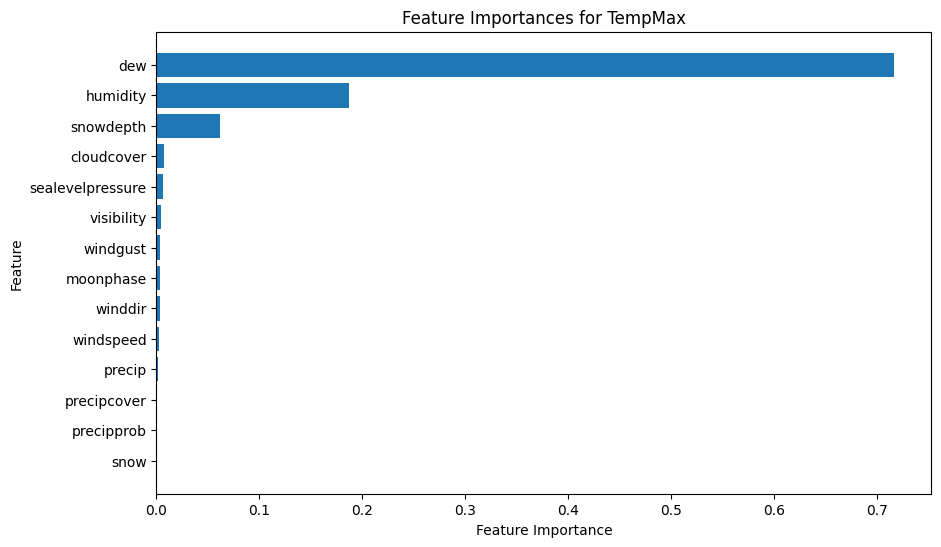

In [25]:
# Get feature importances
feature_importances = rf_max.feature_importances_

# Get sorted feature importances
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [X_max[idx] for idx in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Print sorted feature importances
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"Feature: {feature}, Importance: {importance}")

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances for TempMax")
plt.gca().invert_yaxis()
plt.show()

Number of features needed to reach 95.0% cumulative importance: 3


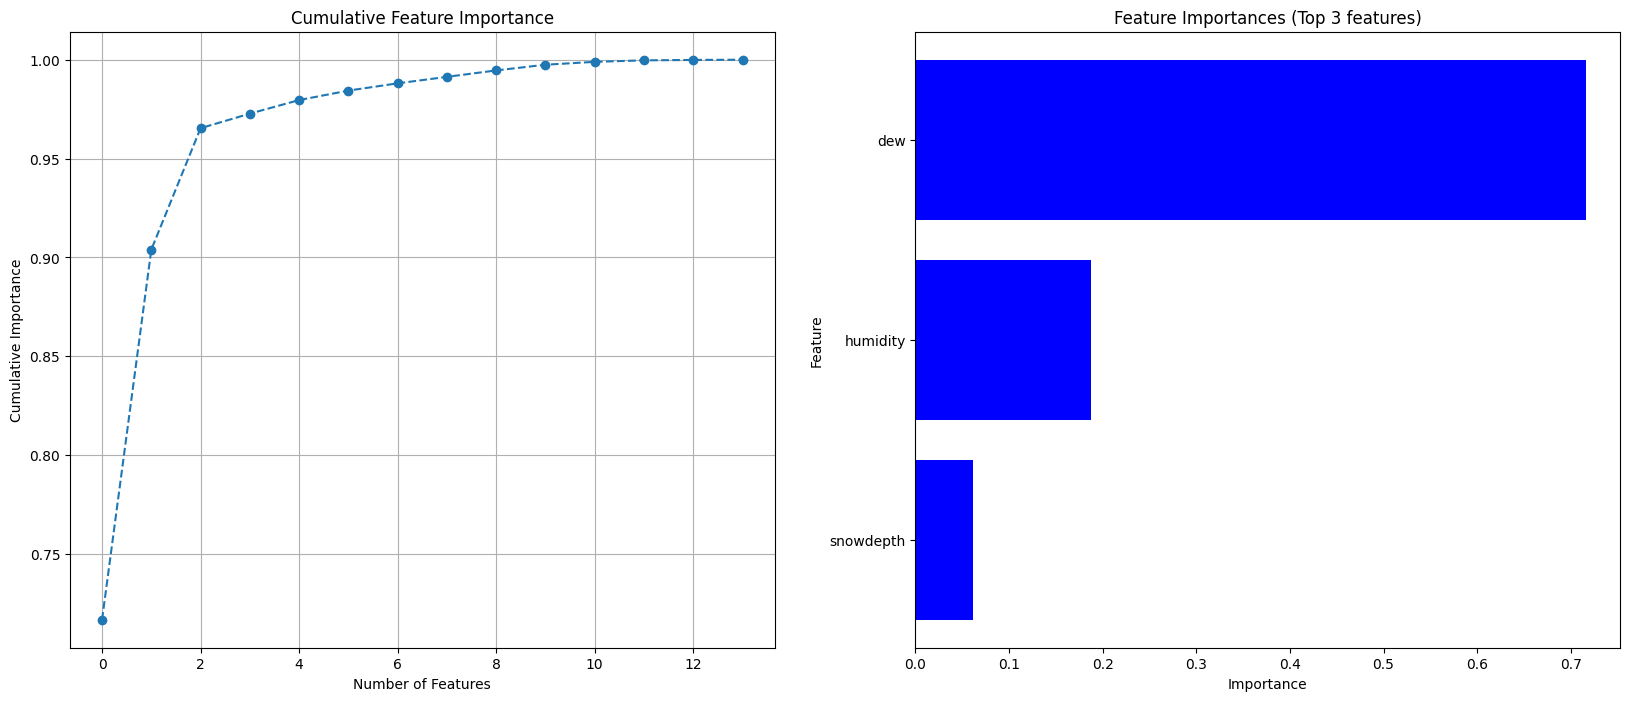

In [26]:
# Get feature importances from the Random Forest model
feature_importances = rf_max.feature_importances_

# Get feature names
feature_names = X_train_max.columns

# Create a sorted list of feature importances
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Calculate cumulative importance
cumulative_importances = np.cumsum(sorted_importances)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot cumulative importance
axes[0].plot(range(len(cumulative_importances)), cumulative_importances, marker='o', linestyle='--')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Cumulative Importance')
axes[0].set_title('Cumulative Feature Importance')
axes[0].grid()

# Set a threshold for cumulative importance
threshold = 0.95
important_idx = np.where(cumulative_importances >= threshold)[0][0] + 1

# Get the most important features
important_features = sorted_features[:important_idx]
important_importances = sorted_importances[:important_idx]

print(f"Number of features needed to reach {threshold*100}% cumulative importance: {important_idx}")

# Plot the important features
axes[1].barh(important_features, important_importances, color='blue')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')
axes[1].set_title(f'Feature Importances (Top {important_idx} features)')
axes[1].invert_yaxis()

plt.show()


In [27]:
# Evaluate Model Performance with Reduced Feature Sets
# Define the updated features for TempMax
X_max = ['dew', 'humidity', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']


# Function to evaluate model performance
def evaluate_model(features, X_train, y_train, X_val, y_val):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train[features], y_train)

    # Cross-validation scores
    cv_scores = cross_val_score(rf, X_train[features], y_train, cv=5)
    mean_cv_score = cv_scores.mean()

    # R² score on validation set
    y_pred = rf.predict(X_val[features])
    r2_val_score = r2_score(y_val, y_pred)

    return mean_cv_score, r2_val_score

# Initial evaluation with all features
mean_cv_score_all, r2_val_score_all = evaluate_model(X_max, X_train_max, y_train_max, X_val_max, y_val_max)
print(f"Initial Mean CV Score: {mean_cv_score_all}")
print(f"Initial R² Score on Validation Set: {r2_val_score_all}")

# Iteratively remove the least important feature and evaluate
for feature in sorted_features[::-1]:
    X_max_reduced = [f for f in X_max if f != feature]
    mean_cv_score, r2_val_score = evaluate_model(X_max_reduced, X_train_max, y_train_max, X_val_max, y_val_max)
    print(f"Removing Feature: {feature}")
    print(f"Mean CV Score: {mean_cv_score}")
    print(f"R² Score on Validation Set: {r2_val_score}")

    if r2_val_score >= r2_val_score_all:  # If performance is not degraded
        X_max = X_max_reduced
        r2_val_score_all = r2_val_score  # Update the best R² score


Initial Mean CV Score: 0.9326525144365269
Initial R² Score on Validation Set: 0.815643021236212
Removing Feature: snow
Mean CV Score: 0.9326525144365269
R² Score on Validation Set: 0.815643021236212
Removing Feature: precipprob
Mean CV Score: 0.9326525144365269
R² Score on Validation Set: 0.815643021236212
Removing Feature: precipcover
Mean CV Score: 0.9326525144365269
R² Score on Validation Set: 0.815643021236212
Removing Feature: precip
Mean CV Score: 0.9326525144365269
R² Score on Validation Set: 0.815643021236212
Removing Feature: windspeed
Mean CV Score: 0.9316262514212733
R² Score on Validation Set: 0.8119753870740984
Removing Feature: winddir
Mean CV Score: 0.9326525144365269
R² Score on Validation Set: 0.815643021236212
Removing Feature: moonphase
Mean CV Score: 0.9338835956758278
R² Score on Validation Set: 0.8202391429054122
Removing Feature: windgust
Mean CV Score: 0.9338835956758278
R² Score on Validation Set: 0.8202391429054122
Removing Feature: visibility
Mean CV Score: 0

In [28]:
# Define the updated features for TempMax
X_max = ['dew', 'humidity', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']

# Define the updated features for TempMin
X_min = ['dew', 'humidity', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']

In [29]:
# Define training and validation sets with updated features
X_train_max = train[X_max]
y_train_max = train[y_max]
X_val_max = validate[X_max]
y_val_max = validate[y_max]

# Initialize and train the Random Forest model - TempMax
rf_max = RandomForestRegressor(n_estimators=100, random_state=42)
rf_max.fit(X_train_max, y_train_max)

# Evaluate the model using cross-validation - TempMax
cv_scores_max = cross_val_score(rf_max, X_train_max, y_train_max, cv=5)
print(f"Cross-Validation Scores Features - TempMax: {cv_scores_max}")
print(f"Mean CV Score Features - TempMax: {cv_scores_max.mean()}")

# Predict and calculate R² score - TempMax
y_pred_max = rf_max.predict(X_val_max)
r2_score_max = r2_score(y_val_max, y_pred_max)
print(f"R² Score Features - TempMax: {r2_score_max}")

# Similarly, repeat for TempMin
X_train_min = train[X_min]
y_train_min = train[y_min]
X_val_min = validate[X_min]
y_val_min = validate[y_min]

# Initialize and train the Random Forest model - TempMin
rf_min = RandomForestRegressor(n_estimators=100, random_state=42)
rf_min.fit(X_train_min, y_train_min)

# Evaluate the model using cross-validation - TempMin
cv_scores_min = cross_val_score(rf_min, X_train_min, y_train_min, cv=5)
print(f"Cross-Validation Scores Features - TempMin: {cv_scores_min}")
print(f"Mean CV Score Features - TempMin: {cv_scores_min.mean()}")

# Predict and calculate R² score - TempMin
y_pred_min = rf_min.predict(X_val_min)
r2_score_min = r2_score(y_val_min, y_pred_min)
print(f"R² Score Features - TempMin: {r2_score_min}")


Cross-Validation Scores Features - TempMax: [0.90964637 0.91634776 0.94327015 0.96035811 0.93364018]
Mean CV Score Features - TempMax: 0.9326525144365269
R² Score Features - TempMax: 0.815643021236212
Cross-Validation Scores Features - TempMin: [0.92109315 0.86681155 0.93313913 0.96824079 0.95139692]
Mean CV Score Features - TempMin: 0.9281363095677608
R² Score Features - TempMin: 0.8669575315244764
